In [1]:
import numpy as np
from scipy.stats import kurtosis as kurt
from brian2 import *
from brian2modelfitting import *

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# set parameters
area = 1000*um**2
C_m = 1.*ufarad*cm**-2*area
E_l = -54.387*mV
E_K = -77.*mV
E_Na = 50.*mV
dt = 0.05*ms
init_conds = {'V': -65*mV, 'm': 0.05, 'h': 0.6, 'n': 0.32}
ground_truth_params = {'g_l': 0.3*mS*cm**-2*area,
                       'g_Na': 120.*mS*cm**-2*area,
                       'g_K': 36.*mS*cm**-2*area}

In [4]:
# load the data and shirnk them up a bit
inp_trace = np.load('data/inp_trace.npy')
out_trace = np.load('data/out_trace_ground_truth.npy')
inp_trace = inp_trace[::5]  # take every 5th recording
out_trace = out_trace[::5]  # -||-

In [5]:
# set up time domain
t = np.arange(0, inp_trace.size*dt/ms, dt/ms)
t_start, t_end = t[np.where(inp_trace != 0)[0][[0, -1]]]

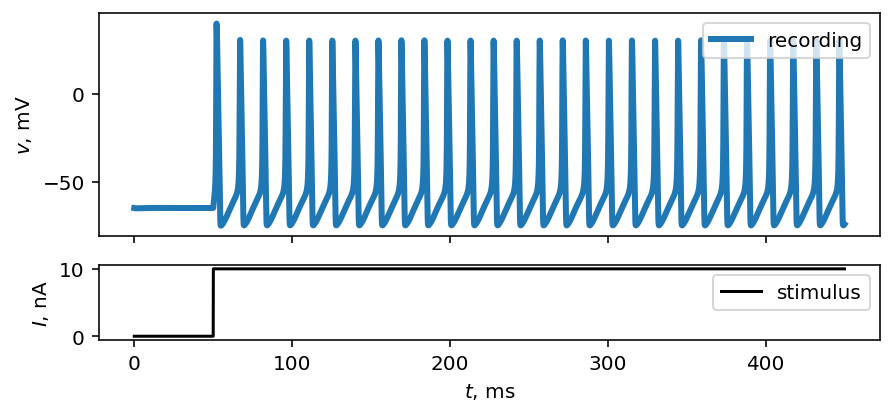

In [6]:
# visualize traces
fig, axs = subplots(2, 1, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 3))
axs[0].plot(t, out_trace, lw=3, label='recording')
axs[0].set_ylabel('$v$, mV')
axs[0].legend(loc='upper right')

axs[1].plot(t, inp_trace, 'k-', label='stimulus')
axs[1].set_xlabel('$t$, ms')
axs[1].set_ylabel('$I$, nA')
axs[1].legend();

In [7]:
# count spikes in output trace
def count_spikes(x):
    x = x.copy()
    # put everything to -10 mV that is below -10 mV or has negative slope
    ind = np.where(x < -0.01)
    x[ind] = -0.01
    ind = np.where(np.diff(x) < 0)
    x[ind] = -0.01

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(x) < 0)
    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[
        (spike_times > t_start) & (spike_times < t_end)
    ]
    
    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]
    return spike_times_stim.shape[0]

num_of_spikes = count_spikes(out_trace)
print(f'{num_of_spikes = }')

num_of_spikes = 28


In [8]:
# set model definintion
eqs = '''
    # ode system
    dV/dt = ((I_inj
          - g_Na * m ** 3 * h * (V - E_Na)
          - g_K * n**4 * (V - E_K)
          - g_l * (V - E_l)) / C_m) : volt
    dm/dt = alpha_m * (1.0 - m) - beta_m * m : 1
    dh/dt = alpha_h * (1.0 - h) - beta_h * h : 1
    dn/dt = alpha_n * (1.0 - n) - beta_n * n : 1

    alpha_m = (0.1*mV**-1) * (V + 40.*mV) / (1. - exp(-(V + 40.*mV) / (10.*mV)))/ms : Hz
    beta_m = 4. * exp(-(V + 65.*mV) / (18.*mV))/ms : Hz
    alpha_h = 0.07 * exp(-(V + 65.*mV) / (20.*mV))/ms : Hz
    beta_h = 1. / (1. + exp(-(V + 35.*mV) / (10.*mV)))/ms : Hz
    alpha_n = (0.01*mV**-1) * (V + 55.*mV) / (1. - exp(-(V + 55.*mV) / (10.*mV)))/ms : Hz
    beta_n = 0.125 * exp(-(V + 65.*mV) / (80.*mV))/ms : Hz

    # parameters to fit
    g_Na : siemens (constant)
    g_K : siemens (constant)
    g_l : siemens (constant)
    '''

In [9]:
# a few features to create a summary statistics representation of traces
A = inp_trace.max() * 1e-9  # amplitude of the stimulus in nA

def ohmic_resistance(x):  # this will probably not going to work for synthetic traces
    x_base = np.mean(x[t < t_start])
    x_steady_state = np.mean(x[t > t_end])
    x_deflection = abs(x_steady_state - x_base)
    return x_deflection / A

features = [
    lambda x: np.max(x[(t > t_start) & (t < t_end)]),  # max active potential
    lambda x: np.mean(x[(t > t_start) & (t < t_end)]),  # mean active potential
    lambda x: np.std(x[(t > t_start) & (t < t_end)]),  # std of active potential
    lambda x: kurt(x[(t > t_start) & (t < t_end)], fisher=False),  # kurtosis of active potential
    lambda x: np.mean(x[(t > 0.25 * t_start) & (t < 0.75 * t_start)]),  # membrane resting potential
    # ohmic_resistance,
]

In [10]:
# inference object instantiation
inferencer = Inferencer(dt=dt, model=eqs,
                        input={
                            'I_inj': inp_trace.reshape(1, -1)*uA*cm**-2*area,
                            },
                        output={
                            'V': out_trace.reshape(1, -1)*mV,
                            # 'spikes': array(num_of_spikes),
                            },
                        features={
                            'V': features,
                        },
                        param_init=init_conds,
                        method='exponential_euler')

In [11]:
# inferencer training
posterior = inferencer.infer(n_samples=10_000,
                             n_rounds=4,
                             inference_method='SNPE',
                             density_estimator_model='mdn',
                             restart=True,
                             g_l=[0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
                             g_Na=[60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
                             g_K=[10.*mS*cm**-2*area, 50.*mS*cm**-2*area])

Extracting features:   0%|          | 0/1 [00:00<?, ?it/s]

4-round focused inference:   0%|          | 0/4 [00:00<?, ?it/s]

Neural network successfully converged after 131 epochs.
Neural network successfully converged after 264 epochs.
Neural network successfully converged after 195 epochs.
Neural network successfully converged after 34 epochs.


In [12]:
# sampling the posterior
samples = inferencer.sample((10_000, ))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

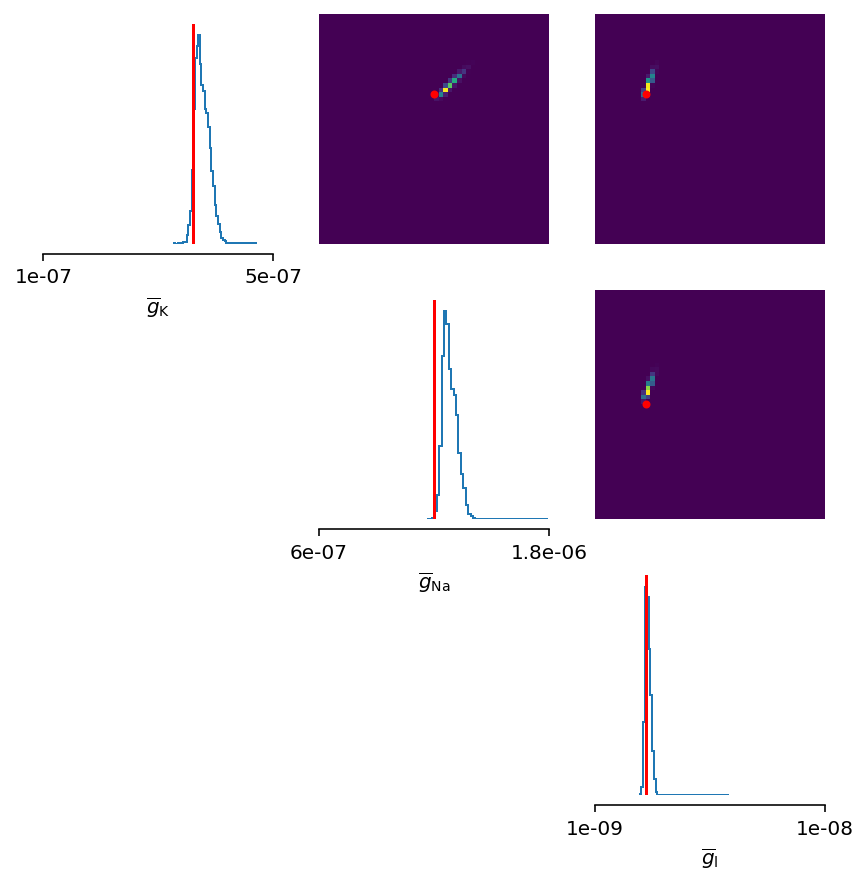

In [13]:
# visualization of parameter space
limits = {'g_l': [0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
          'g_Na': [60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
          'g_K': [10.*mS*cm**-2*area, 50.*mS*cm**-2*area]}
labels = {'g_l': r'$\overline{g}_\mathrm{l}$',
          'g_Na': r'$\overline{g}_\mathrm{Na}$',
          'g_K': r'$\overline{g}_\mathrm{K}$'}
inferencer.pairplot(limits=limits,
                    ticks=limits,
                    labels=labels,
                    points=ground_truth_params,
                    points_offdiag={'markersize': 6},
                    points_colors = ['r'],
                    figsize=(7, 7));

In [14]:
# generating the fitted trace using a sample from posterior
inf_trace = inferencer.generate_traces()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

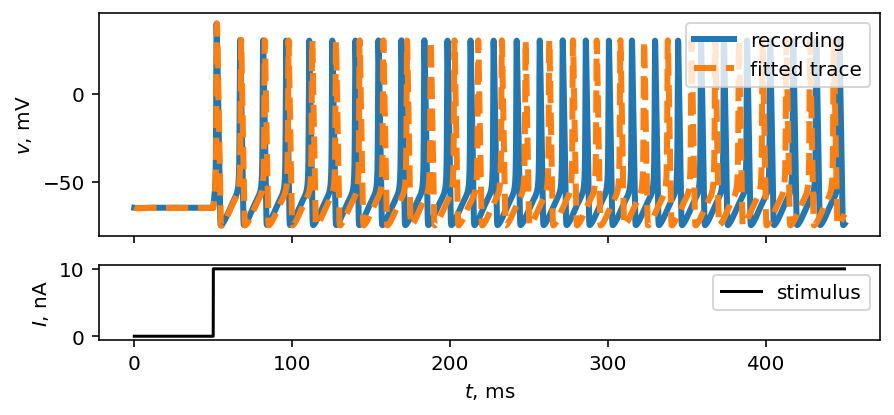

In [17]:
# visualize traces
fig, axs = subplots(2, 1, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 3))
axs[0].plot(t, out_trace, lw=3, label='recording')
axs[0].plot(t, inf_trace.ravel()/mV, '--', lw=3, label='fitted trace')
axs[0].set_ylabel('$v$, mV')
axs[0].legend(loc='upper right')

axs[1].plot(t, inp_trace, 'k-', label='stimulus')
axs[1].set_xlabel('$t$, ms')
axs[1].set_ylabel('$I$, nA')
axs[1].legend();